<img src="https://www.bportugal.pt/sites/default/files/imagens/3loilpa0he-bplogo-en.png" height="50"/>  
**Machine learning: tools and applications for policy**  
Day 3: NLTK and sentiment analysis

19-21 September 2022  

**Instructors**  
Prof. Iman van Lelyveld (iman.van.lelyveld@vu.nl)<br/>
Dr. Dieter Wang (d.wang@vu.nl)  

# Preparation

In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
!pip install twython 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load articles from the FT
The file `data/df_articles.csv` contains 436 articles from the Financial Times on the topic of Environmental, Social and Governance (ESG) between March 2021 and 2022.

In [ ]:
!wget -O bdp2022-material.zip https://dieter.wang/files/bdp2022-material.zip
!unzip -o bdp2022-material.zip

--2022-10-11 04:32:42--  https://dieter.wang/files/bdp2022-material.zip
Resolving dieter.wang (dieter.wang)... 85.13.135.217
Connecting to dieter.wang (dieter.wang)|85.13.135.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7092168 (6.8M) [application/zip]
Saving to: ‘bdp2022-material.zip’

bdp2022-material.zi 100%[===================>]   6.76M  4.03MB/s    in 1.7s    

2022-10-11 04:32:44 (4.03 MB/s) - ‘bdp2022-material.zip’ saved [7092168/7092168]

Archive:  bdp2022-material.zip
  inflating: data/application_record.csv  
  inflating: data/credit_record.csv  
  inflating: data/df_articles.csv    
  inflating: images/fig_linreg-logitreg.png  
  inflating: images/fig_precision.png  
  inflating: images/fig_recall.png   
  inflating: images/fig_reg-vs-clf.png  
  inflating: images/fig_vlookup.png  
  inflating: images/SQL-LEFT-JOIN.png  


In [ ]:
df_articles = pd.read_csv('data/df_articles.csv')
df_articles

,id,date,title,body
0,104fcb71d5be83799550,2022-02-26,WOMEN OF 2021 ...................................,"Bonus season 2022 survey: will you invest, sav..."
1,642e9f5f43ea0e93e403,2022-02-26,Ckimate change: Your chance to quiz the FT,Young people have been vocal in calling for mo...
2,0b4ce70ddf4f79e15ab8,2022-02-24,Short selling has as much carbon impact as div...,"Letters The piece ""Short selling does not coun..."
3,92620ee8c2bd94174f5a,2022-02-23,AllianzGI to vote against pay deals with no ES...,Asset management Allianz Global Investors has ...
4,fa64a3d9f6e4c96473cd,2022-02-23,Allianz in pay warning over ESG values,Briefing The investment group with €673bn in a...
...,...,...,...,...
431,4ea4bab4c0ec22b8ccf0,2021-03-03,Danone: half measures,"Twitter: @FTLex ""Wanted: new chief executive f..."
432,e5ae8d267e694b33f603,2021-03-03,Cevian warns boards to include ESG metrics in ...,"Financials Cevian Capital, Europe's largest ac..."
433,a47bde0efbbe7c310103,2021-03-03,Orbia finds breaking up is hard to do after to...,"A t the start of this year, Mexican conglomera..."
434,a4e82470212a8b9e61ef,2021-03-01,What can we learn from those at the top?,FT series: Leaders' Lessons Over the coming mo...


# Extract tokens from the text
Current, the article is stored as `date`, `title` and `body`. Our focus will be on `body`. This is currently stored as a long string of text. See example below

In [ ]:
df_articles.loc[10, 'title']

'Merryn Somerset Webb Investing'

In [ ]:
df_articles.loc[10, 'body']

'Divesting fossil fuel stocks? That\'s so last year G ood news. You can now get 1.3 per cent on a Green Savings Bond at National Savings & Investments. Eagle-eyed readers will note that this is 4.2 percentage points less than the rate of inflation in the UK, as the latest CPI numbers came in at 5.5 per cent. That\'s true and something of a problem but nonetheless 1.3 per cent is better than the 0.65 per cent NS&I offered at the launch of the bonds a few months ago. NS&I says this is based on the rise in base rates since October when it first launched the bond. Bank of England rates up, NS&I rates up. But if that were all it was, it would make sense for the new rate to be 1.05 per cent as the Bank of England has put rates up by 0.4 percentage points. Perhaps then, the sharp rise is less to do with base rates than the lack of interest in the initial launch. NS&I reckoned that the very word "green" would people get in, that they\'d be happy to limit their returns just to know that their m

This is not particularly useful as we want to extract meaningful words. For example, "green" or "inflation" or "rise". For this we first have to splice the `body` into individual tokens, that are separated by whitespaces. The regular expression `'\w+'` means one or more alphanumeric characters. 

In [ ]:
from nltk.tokenize import RegexpTokenizer

# \w+ means at least one white space or line break character

regexp = RegexpTokenizer('\w+')

In [ ]:
df_articles['body_tokenize'] = df_articles['body'].apply(regexp.tokenize)

In [ ]:
df_articles.loc[0, 'body']

'Bonus season 2022 survey: will you invest, save or spend? Despite the horrors inflicted on us all by the masters of the universe in the global financial crisis, it still appears to be business as usual for one sector of the UK economy. The sector that, incidentally, has also helped to serve the lifestyles of a kleptocracy that now threatens to inflict the greatest conflict on Europe since the second world war. gorbon143, via FT.com Given the painful fall in living standards about to hit the majority of the population, surely this would be a very good time to stay diplomatically quiet about a bumper bankers\' bonus season? Medium Rare Earth, via FT.com Divesting fossil fuel stocks? That\'s so last year Money managers will leap on any bandwagon to attract investor capital and generate fees which are paid regardless of how investments perform. When ESG is exhausted, they\'ll move on to something else. DinToronto, via FT.com One of the reasons why green stocks will tank is that they suppo

In [ ]:
df_articles.loc[0, 'body_tokenize']

['Bonus',
 'season',
 '2022',
 'survey',
 'will',
 'you',
 'invest',
 'save',
 'or',
 'spend',
 'Despite',
 'the',
 'horrors',
 'inflicted',
 'on',
 'us',
 'all',
 'by',
 'the',
 'masters',
 'of',
 'the',
 'universe',
 'in',
 'the',
 'global',
 'financial',
 'crisis',
 'it',
 'still',
 'appears',
 'to',
 'be',
 'business',
 'as',
 'usual',
 'for',
 'one',
 'sector',
 'of',
 'the',
 'UK',
 'economy',
 'The',
 'sector',
 'that',
 'incidentally',
 'has',
 'also',
 'helped',
 'to',
 'serve',
 'the',
 'lifestyles',
 'of',
 'a',
 'kleptocracy',
 'that',
 'now',
 'threatens',
 'to',
 'inflict',
 'the',
 'greatest',
 'conflict',
 'on',
 'Europe',
 'since',
 'the',
 'second',
 'world',
 'war',
 'gorbon143',
 'via',
 'FT',
 'com',
 'Given',
 'the',
 'painful',
 'fall',
 'in',
 'living',
 'standards',
 'about',
 'to',
 'hit',
 'the',
 'majority',
 'of',
 'the',
 'population',
 'surely',
 'this',
 'would',
 'be',
 'a',
 'very',
 'good',
 'time',
 'to',
 'stay',
 'diplomatically',
 'quiet',
 'about

# Convert all words to lower case

In [ ]:
def convert_to_lowercase(list_of_tokens):
  return [tk.lower() for tk in list_of_tokens]

In [ ]:
convert_to_lowercase(['BaBaBa','bbbb','AAAA'])

['bababa', 'bbbb', 'aaaa']

In [ ]:
df_articles['body_tokenize'] = df_articles['body_tokenize'].apply(convert_to_lowercase)

In [ ]:
df_articles.loc[10, 'body_tokenize']

['divesting',
 'fossil',
 'fuel',
 'stocks',
 'that',
 's',
 'so',
 'last',
 'year',
 'g',
 'ood',
 'news',
 'you',
 'can',
 'now',
 'get',
 '1',
 '3',
 'per',
 'cent',
 'on',
 'a',
 'green',
 'savings',
 'bond',
 'at',
 'national',
 'savings',
 'investments',
 'eagle',
 'eyed',
 'readers',
 'will',
 'note',
 'that',
 'this',
 'is',
 '4',
 '2',
 'percentage',
 'points',
 'less',
 'than',
 'the',
 'rate',
 'of',
 'inflation',
 'in',
 'the',
 'uk',
 'as',
 'the',
 'latest',
 'cpi',
 'numbers',
 'came',
 'in',
 'at',
 '5',
 '5',
 'per',
 'cent',
 'that',
 's',
 'true',
 'and',
 'something',
 'of',
 'a',
 'problem',
 'but',
 'nonetheless',
 '1',
 '3',
 'per',
 'cent',
 'is',
 'better',
 'than',
 'the',
 '0',
 '65',
 'per',
 'cent',
 'ns',
 'i',
 'offered',
 'at',
 'the',
 'launch',
 'of',
 'the',
 'bonds',
 'a',
 'few',
 'months',
 'ago',
 'ns',
 'i',
 'says',
 'this',
 'is',
 'based',
 'on',
 'the',
 'rise',
 'in',
 'base',
 'rates',
 'since',
 'october',
 'when',
 'it',
 'first',
 'launc

# Remove stopwords and short words
This is much better. But many words are not informative, which are what we call "stopwords".

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

We want to filter out these words and only keep the meaningful ones. Moreover, short words that are one or two characters long can also be removed.

In [ ]:
def remove_stopwords(tokens):
    non_stopwords_tokens = []
    for tk in tokens:
        if len(tk) <= 3:
            # if the token is less than 3 characters long, jump to next token
            continue

        if any([a.isnumeric() for a in tk]):
            # if the token is numeric, e.g. '34' yields true
            continue

        if tk in stopwords:
            # if the token is a stopword, jump to next token
            continue

        # if no jumps happened, then add the token to the results
        non_stopwords_tokens.append(tk)

    return non_stopwords_tokens

In [ ]:
remove_stopwords([
    'ab',
    'abc',
    'only',
    '2020a',
    'England',
    'ESG',
])

['England']

In [ ]:
df_articles['body_tokenize_nonstop'] = df_articles['body_tokenize'].apply(remove_stopwords)

In [ ]:
df_articles.loc[10, 'body_tokenize_nonstop']

['divesting',
 'fossil',
 'fuel',
 'stocks',
 'last',
 'year',
 'news',
 'cent',
 'green',
 'savings',
 'bond',
 'national',
 'savings',
 'investments',
 'eagle',
 'eyed',
 'readers',
 'note',
 'percentage',
 'points',
 'less',
 'rate',
 'inflation',
 'latest',
 'numbers',
 'came',
 'cent',
 'true',
 'something',
 'problem',
 'nonetheless',
 'cent',
 'better',
 'cent',
 'offered',
 'launch',
 'bonds',
 'months',
 'says',
 'based',
 'rise',
 'base',
 'rates',
 'since',
 'october',
 'first',
 'launched',
 'bond',
 'bank',
 'england',
 'rates',
 'rates',
 'would',
 'make',
 'sense',
 'rate',
 'cent',
 'bank',
 'england',
 'rates',
 'percentage',
 'points',
 'perhaps',
 'sharp',
 'rise',
 'less',
 'base',
 'rates',
 'lack',
 'interest',
 'initial',
 'launch',
 'reckoned',
 'word',
 'green',
 'would',
 'people',
 'happy',
 'limit',
 'returns',
 'know',
 'money',
 'somehow',
 'good',
 'seems',
 'wrong',
 'important',
 'gives',
 'small',
 'clue',
 'might',
 'happen',
 'next',
 'investing',
 '

# Stemming and lemmatization

Great, now we need to use stemming or lemmatization to identify inflected forms of a word. I.e. `look` is the base form, but we usually see words like `looking`, `looks`, `looked` etc. Lemmatization goes a step further and also takes the context into account.

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer().lemmatize

In [ ]:
lemmatizer('bikes')

'bike'

In [ ]:
lemmatizer('going')

'going'

In [ ]:
def lemmatize_each_word(words):
    lemmatized_words = []
    for word in words:
        lemmatized = lemmatizer(word)
        lemmatized_words.append(lemmatized)
    return lemmatized_words

In [ ]:
lemmatize_each_word(df_articles.loc[10, 'body_tokenize_nonstop'])

['divesting',
 'fossil',
 'fuel',
 'stock',
 'last',
 'year',
 'news',
 'cent',
 'green',
 'saving',
 'bond',
 'national',
 'saving',
 'investment',
 'eagle',
 'eyed',
 'reader',
 'note',
 'percentage',
 'point',
 'le',
 'rate',
 'inflation',
 'latest',
 'number',
 'came',
 'cent',
 'true',
 'something',
 'problem',
 'nonetheless',
 'cent',
 'better',
 'cent',
 'offered',
 'launch',
 'bond',
 'month',
 'say',
 'based',
 'rise',
 'base',
 'rate',
 'since',
 'october',
 'first',
 'launched',
 'bond',
 'bank',
 'england',
 'rate',
 'rate',
 'would',
 'make',
 'sense',
 'rate',
 'cent',
 'bank',
 'england',
 'rate',
 'percentage',
 'point',
 'perhaps',
 'sharp',
 'rise',
 'le',
 'base',
 'rate',
 'lack',
 'interest',
 'initial',
 'launch',
 'reckoned',
 'word',
 'green',
 'would',
 'people',
 'happy',
 'limit',
 'return',
 'know',
 'money',
 'somehow',
 'good',
 'seems',
 'wrong',
 'important',
 'give',
 'small',
 'clue',
 'might',
 'happen',
 'next',
 'investing',
 'world',
 'past',
 'yea

In [ ]:
df_articles['body_tokenize_nonstop_lemma'] = df_articles['body_tokenize_nonstop'].apply(lemmatize_each_word)

# Assign sentiments 

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer().polarity_scores

In [ ]:
analyzer('good')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}

In [ ]:
analyzer('bad')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}

In [ ]:
analyzer('I like coffee')

{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612}

In [ ]:
def get_sentiment(list_of_words):
    words = ' '.join(list_of_words)
    analyzed = analyzer(words)
    return analyzed['compound']

In [ ]:
get_sentiment(['I', 'like', 'coffee'])

0.3612

In [ ]:
df_articles['sentiment'] = df_articles['body_tokenize_nonstop_lemma'].apply(get_sentiment)

In [ ]:
df_articles['sentiment']

0      0.9808
1      0.9246
2      0.9883
3      0.9623
4     -0.2500
        ...  
431    0.9442
432    0.9729
433    0.9758
434    0.9990
435    0.9997
Name: sentiment, Length: 436, dtype: float64

# Plot results

In [ ]:
df_articles.head()

,id,date,title,body,body_tokenize,body_tokenize_nonstop,body_tokenize_nonstop_lemma,sentiment
0,104fcb71d5be83799550,2022-02-26,WOMEN OF 2021 ...................................,"Bonus season 2022 survey: will you invest, sav...","[bonus, season, 2022, survey, will, you, inves...","[bonus, season, survey, invest, save, spend, d...","[bonus, season, survey, invest, save, spend, d...",0.9808
1,642e9f5f43ea0e93e403,2022-02-26,Ckimate change: Your chance to quiz the FT,Young people have been vocal in calling for mo...,"[young, people, have, been, vocal, in, calling...","[young, people, vocal, calling, action, fight,...","[young, people, vocal, calling, action, fight,...",0.9246
2,0b4ce70ddf4f79e15ab8,2022-02-24,Short selling has as much carbon impact as div...,"Letters The piece ""Short selling does not coun...","[letters, the, piece, short, selling, does, no...","[letters, piece, short, selling, count, carbon...","[letter, piece, short, selling, count, carbon,...",0.9883
3,92620ee8c2bd94174f5a,2022-02-23,AllianzGI to vote against pay deals with no ES...,Asset management Allianz Global Investors has ...,"[asset, management, allianz, global, investors...","[asset, management, allianz, global, investors...","[asset, management, allianz, global, investor,...",0.9623
4,fa64a3d9f6e4c96473cd,2022-02-23,Allianz in pay warning over ESG values,Briefing The investment group with €673bn in a...,"[briefing, the, investment, group, with, 673bn...","[briefing, investment, group, assets, manageme...","[briefing, investment, group, asset, managemen...",-0.2500


We now have the desired results. We would like to plot these over time. So let's extract the `sentiment` column and plot it.

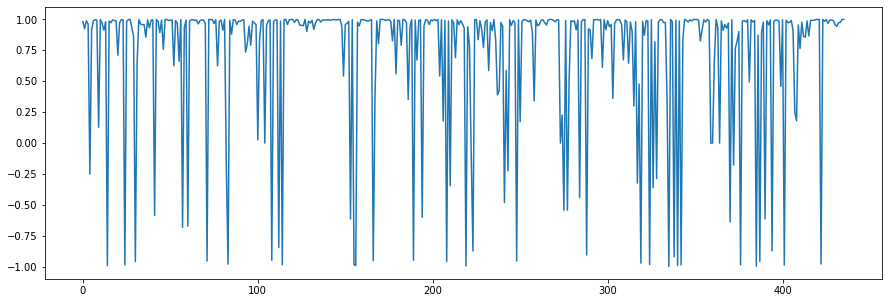

In [ ]:
df_articles['sentiment'].plot(figsize=[15,5])

This is very messy. There are several issues here that need to be addressed
1. The x-axis is wrong, it should be based on dates, not number of entries.
2. The series is very volatile, we are looking for a trend.

Let us first make our problem easier. `df_articles` contains all the data we constructed throughout the notebook. For plotting, however, we only need two columns: (a) the `date` column as the index and (b) the `sentiment` column for the actual time series values.

In [ ]:
df_articles.head(5)

,id,date,title,body,body_tokenize,body_tokenize_nonstop,body_tokenize_nonstop_lemma,sentiment
0,104fcb71d5be83799550,2022-02-26,WOMEN OF 2021 ...................................,"Bonus season 2022 survey: will you invest, sav...","[bonus, season, 2022, survey, will, you, inves...","[bonus, season, survey, invest, save, spend, d...","[bonus, season, survey, invest, save, spend, d...",0.9808
1,642e9f5f43ea0e93e403,2022-02-26,Ckimate change: Your chance to quiz the FT,Young people have been vocal in calling for mo...,"[young, people, have, been, vocal, in, calling...","[young, people, vocal, calling, action, fight,...","[young, people, vocal, calling, action, fight,...",0.9246
2,0b4ce70ddf4f79e15ab8,2022-02-24,Short selling has as much carbon impact as div...,"Letters The piece ""Short selling does not coun...","[letters, the, piece, short, selling, does, no...","[letters, piece, short, selling, count, carbon...","[letter, piece, short, selling, count, carbon,...",0.9883
3,92620ee8c2bd94174f5a,2022-02-23,AllianzGI to vote against pay deals with no ES...,Asset management Allianz Global Investors has ...,"[asset, management, allianz, global, investors...","[asset, management, allianz, global, investors...","[asset, management, allianz, global, investor,...",0.9623
4,fa64a3d9f6e4c96473cd,2022-02-23,Allianz in pay warning over ESG values,Briefing The investment group with €673bn in a...,"[briefing, the, investment, group, with, 673bn...","[briefing, investment, group, assets, manageme...","[briefing, investment, group, asset, managemen...",-0.2500


## Getting the dates right

In [ ]:
sr_sentiment = df_articles.set_index('date')
sr_sentiment = sr_sentiment['sentiment']

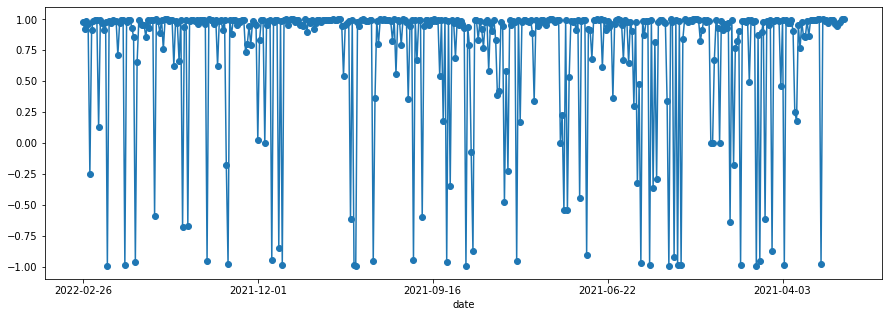

In [ ]:
sr_sentiment.plot(figsize=[15,5], marker='o')

This looks identical as the previous figure, only that the x-labels are different. If we look closely, however, the dates are not actual dates. Instead, these are texts. Let's have a look at the index of `sr_sentiment`

In [ ]:
sr_sentiment.index

Index(['2022-02-26', '2022-02-26', '2022-02-24', '2022-02-23', '2022-02-23',
       '2022-02-22', '2022-02-21', '2022-02-21', '2022-02-21', '2022-02-21',
       ...
       '2021-03-08', '2021-03-06', '2021-03-06', '2021-03-05', '2021-03-05',
       '2021-03-03', '2021-03-03', '2021-03-03', '2021-03-01', '2021-02-27'],
      dtype='object', name='date', length=436)

The `dtype='object'` means that the index is just a list of string values. We want to have dates.

In [ ]:
sr_sentiment.index = pd.to_datetime(sr_sentiment.index)
sr_sentiment.index

DatetimeIndex(['2022-02-26', '2022-02-26', '2022-02-24', '2022-02-23',
               '2022-02-23', '2022-02-22', '2022-02-21', '2022-02-21',
               '2022-02-21', '2022-02-21',
               ...
               '2021-03-08', '2021-03-06', '2021-03-06', '2021-03-05',
               '2021-03-05', '2021-03-03', '2021-03-03', '2021-03-03',
               '2021-03-01', '2021-02-27'],
              dtype='datetime64[ns]', name='date', length=436, freq=None)

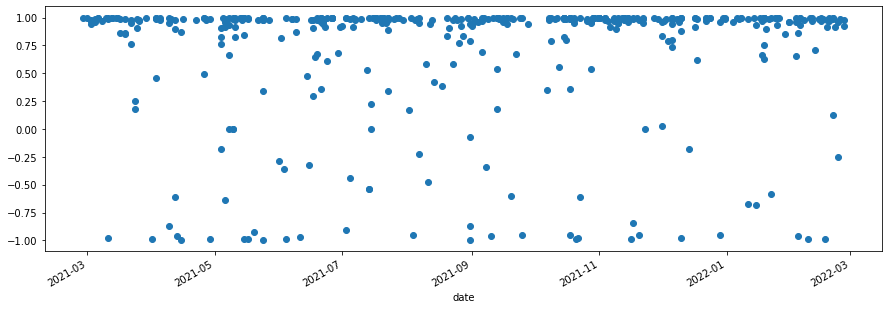

In [ ]:
sr_sentiment.plot(figsize=[15,5], marker='o', lw=0)

## Ensuring a consistent timeseries

What's different? A lot of diagonal lines appear that seem to jump between data points. This is usually a sign of interpolation and missing values. 

Can we see the missing values? Let's have look at `sr_sentiment`. Notice anytihng strange?

In [ ]:
sr_sentiment

date
2022-02-26    0.9808
2022-02-26    0.9246
2022-02-24    0.9883
2022-02-23    0.9623
2022-02-23   -0.2500
               ...  
2021-03-03    0.9442
2021-03-03    0.9729
2021-03-03    0.9758
2021-03-01    0.9990
2021-02-27    0.9997
Name: sentiment, Length: 436, dtype: float64

.  
.  
.  
.  
.  
.  
.  
Indeed! There are two data points for the `2022-02-26`. We should only have on value for each day. Also, ther edoes not seem to be a value for `2022-02-05`.

Thanks to the index being in date format, we can make use of pandas' powerful datetime function. Let's "resample" the dataset and compute the average value for each day. 

In [ ]:
sr_sentiment

date
2022-02-26    0.9808
2022-02-26    0.9246
2022-02-24    0.9883
2022-02-23    0.9623
2022-02-23   -0.2500
               ...  
2021-03-03    0.9442
2021-03-03    0.9729
2021-03-03    0.9758
2021-03-01    0.9990
2021-02-27    0.9997
Name: sentiment, Length: 436, dtype: float64

In [ ]:
# for days
sr_sentiment.resample('D').mean()

date
2021-02-27    0.99970
2021-02-28        NaN
2021-03-01    0.99900
2021-03-02        NaN
2021-03-03    0.96430
               ...   
2022-02-22    0.91360
2022-02-23    0.35615
2022-02-24    0.98830
2022-02-25        NaN
2022-02-26    0.95270
Freq: D, Name: sentiment, Length: 365, dtype: float64

In [ ]:
# for months
sr_sentiment.resample('D').mean()

date
2021-02-27    0.99970
2021-02-28        NaN
2021-03-01    0.99900
2021-03-02        NaN
2021-03-03    0.96430
               ...   
2022-02-22    0.91360
2022-02-23    0.35615
2022-02-24    0.98830
2022-02-25        NaN
2022-02-26    0.95270
Freq: D, Name: sentiment, Length: 365, dtype: float64

In [ ]:
sr_sentiment = sr_sentiment.resample('D').mean()
sr_sentiment

date
2021-02-27    0.99970
2021-02-28        NaN
2021-03-01    0.99900
2021-03-02        NaN
2021-03-03    0.96430
               ...   
2022-02-22    0.91360
2022-02-23    0.35615
2022-02-24    0.98830
2022-02-25        NaN
2022-02-26    0.95270
Freq: D, Name: sentiment, Length: 365, dtype: float64

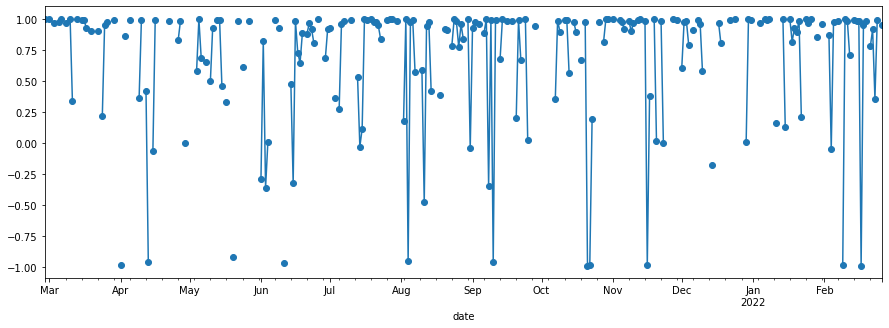

In [ ]:
sr_sentiment.plot(figsize=[15,5], marker='o')

## Dealing with missing values

What should we do with the missing data? We have several options
1. Fill with zeros.
2. Fill with most recent known value.
3. Fill by interpolating between last known and next known values.

What should we do?

.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
Since there were not reports on the dates with missing values, one could argue that there was nothing worth reporting about. Thus, zeros would be a neutral way to deal with the missing values, since it denotes neither positive nor negative sentiments.

In [ ]:
sr_sentiment = sr_sentiment.fillna(0)

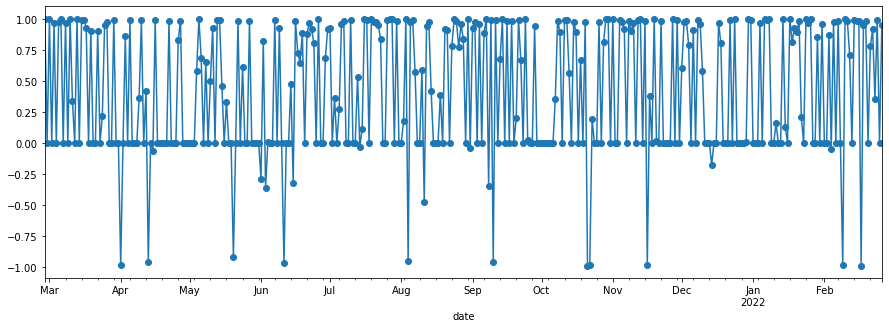

In [ ]:
sr_sentiment.plot(figsize=[15,5], marker='o')

## Aggregating over time

The data points before are shown as raw data. That each, each day has a value. However, we are interested in trends. For example, the moving average over a week or a month.

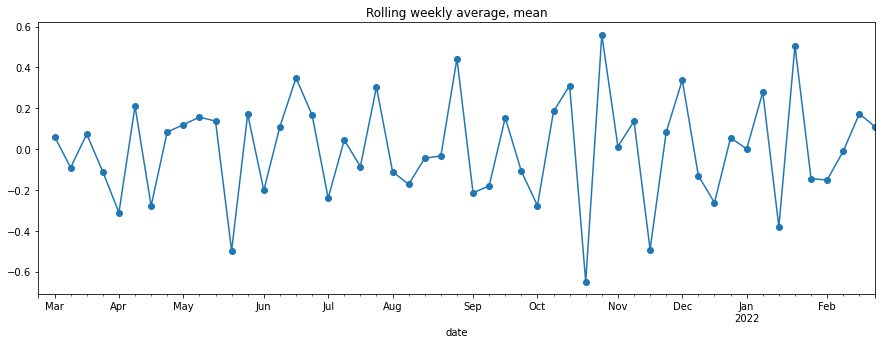

In [ ]:
sr_sentiment_week = sr_sentiment.resample('W').mean().diff()
sr_sentiment_week.plot(figsize=[15,5], marker='o', title='Rolling weekly average, mean')

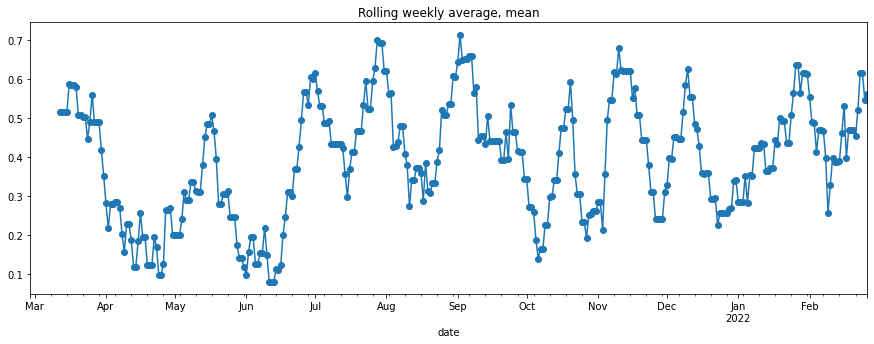

In [ ]:
sr_sentiment_week = sr_sentiment.rolling(14).mean()
sr_sentiment_week.plot(figsize=[15,5], marker='o', title='Rolling weekly average, mean')

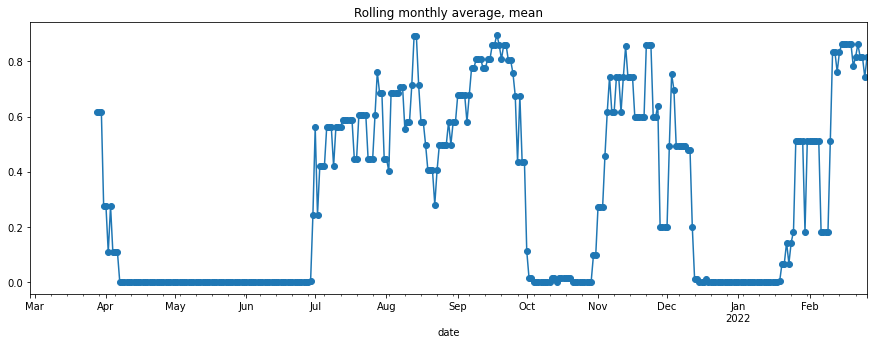

In [ ]:
sr_sentiment_month = sr_sentiment.rolling(30).median()
sr_sentiment_month.plot(figsize=[15,5], marker='o', title='Rolling monthly average, mean')

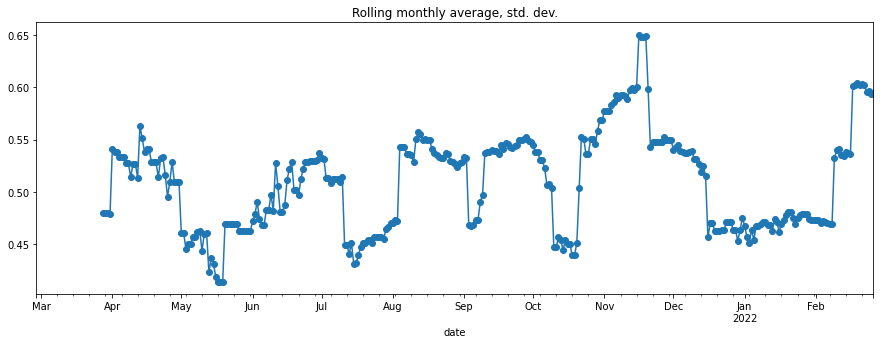

In [ ]:
sr_sentiment_month = sr_sentiment.rolling(30).std()
sr_sentiment_month.plot(figsize=[15,5], marker='o', title='Rolling monthly average, std. dev.')

# Translating word counts into features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
countvec = CountVectorizer()

In [ ]:
X = countvec.fit_transform(df_articles['body_tokenize_nonstop_lemma'].str.join(' '))

In [ ]:
df_features = pd.DataFrame(
    X.toarray(), 
    columns=countvec.get_feature_names_out()
)

In [ ]:
df_features

,aacsb,aalto,aamir,aaron,aarts,abandon,abandoned,abandoning,abandonment,abate,...,zinner,zoho,zone,zoology,zoom,zoomers,zucker,zuercher,zuid,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
433,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
